# Convert existing Tensorflow code to Ray AIR

If you already have working Tensorflow code, you don’t have to start from scratch to utilize the benefits of Ray AIR. Instead, you can continue to use your existing code and incrementally add Ray AIR components as needed.

Some of the benefits you’ll get by using Ray AIR with your existing Tensorflow training code:

- Easy distributed data-parallel training on a cluster
- Automatic checkpointing/fault tolerance and result tracking
- Parallel data preprocessing
- Seamless integration with hyperparameter tuning
- Scalable batch prediction
- Scalable model serving

This tutorial will show you how to start with Ray AIR from your existing Tensorflow training code. We will learn how to perform **distributed data-parallel training** and do **scalable batch prediction**.

## Example Code

The example code we’ll be using is that of the [Tensorflow quickstart tutorial](https://www.tensorflow.org/tutorials/quickstart/beginner). This code trains a convolutional neural network classifier on the MNIST dataset.

Follow along this example by launching the notebook using the 🚀 icon above!

## Existing Tensorflow Code

Let’s start with the unmodified code from the example. A thorough explanation of the parts is given in the full tutorial - we’ll just focus on the code here.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


First, we load and preprocess the MNIST dataset.

Assumption for this tutorial: your existing code is using the `tf.data.Dataset` native to Tensorflow. This tutorial continues to use `tf.data.Dataset` to allow you to make as few code changes as possible. **Everything in this tutorial is also possible if you choose to use Ray Data, and you will also get the benefits of efficient preprocessing and multi-worker batch prediction.** See [here](train-datasets) for resources to get started with Ray Data.

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

N = 1024

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train[:N], y_train[:N])).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

2022-09-30 16:07:11.109865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-30 16:07:11.109896: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Next, we define the model architecture of the convolutional neural network. We wrap the model definition inside a function for easy reuse later.

In [2]:
def build_model() -> tf.keras.Model:
    return tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28)),
            tf.keras.layers.Reshape((28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )

Next, initialize the model, loss, optimizer, and define some metrics that we want to track during training.

We recommend using the Keras `Model.fit` API, as it simplifies distributing your training with `tf.distribute` and Ray AIR. Compile your model with a loss function and optimizer, then run `model.fit(train_ds)`.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

model = build_model()
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=["accuracy"],
)

Lastly, we have the training loop, which trains the model for some number of epochs. Each epoch will loop through the entire training dataset and perform gradient descent steps.

One slight difference between the Tensorflow tutorial and this training loop is that we choose to train one epoch at a time rather than specifying multiple epochs through `model.fit(..., epochs=epochs)`. This will allow us to perform evaluation on the test dataset per epoch, as well as enable per epoch checkpointing and reporting.

In [ ]:
epochs = 5

for epoch in range(epochs):
    # Fit the model for one epoch and evaluate
    train_history = model.fit(train_ds)
    eval_result = model.evaluate(test_ds, return_dict=True)

    # Pull the training and evaluation metrics
    train_result = {key: val[0] for key, val in train_history.history.items()}
    train_loss = train_result["loss"]
    train_accuracy = train_result["accuracy"]
    
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    
    # Print out the metrics
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss}, '
        f'Accuracy: {train_accuracy * 100}, '
        f'Test Loss: {test_loss}, '
        f'Test Accuracy: {test_accuracy * 100}'
    )

## Wrap everything in a training loop function

Later on, we might want to perform hyperparameter optimization and launch multiple training runs, so it is useful to wrap the training logic we have so far in a function. We also introduce a function to get the training and test datasets, which is used within the training function.

In [3]:
def get_train_test_datasets(batch_size):
    N = 1024
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train[:N], y_train[:N])).shuffle(len(x_train)).batch(batch_size)

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    return train_ds, test_ds

def train_func():
    epochs = 5
    batch_size = 32

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()

    model = build_model()
    model.compile(
        optimizer=optimizer,
        loss=loss_object,
        metrics=["accuracy"],
    )
    
    train_ds, test_ds = get_train_test_datasets(batch_size)
    
    for epoch in range(epochs):
        # Fit the model for one epoch and evaluate
        train_history = model.fit(train_ds)
        eval_result = model.evaluate(test_ds, return_dict=True)

        # Pull the training and evaluation metrics
        train_result = {key: val[0] for key, val in train_history.history.items()}
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]

        test_loss = eval_result["loss"]
        test_accuracy = eval_result["accuracy"]

        # Print out the metrics
        print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss}, '
            f'Accuracy: {train_accuracy * 100}, '
            f'Test Loss: {test_loss}, '
            f'Test Accuracy: {test_accuracy * 100}'
        )

## Introduce Ray AIR for Distributed Data-Parallel Training

Now that we have set up a training loop that runs on a single worker, let's use Ray AIR to implement **distributed training**, allowing us to train using any number of workers!

Ray Train, the model training library within Ray AIR, implements a `TensorflowTrainer` that creates workers within a Ray cluster and configures the `TF_CONFIG` environment variable so that you can run [distributed training with Tensorflow](https://www.tensorflow.org/guide/distributed_training) without needing to handle workers manually. This way, you can use simply use a strategy from `tf.distribute` to run your training loop across multiple workers in a distributed data-parallel fashion! The strategy Train supports is [`tf.distribute.MultiWorkerMirroredStrategy`](https://www.tensorflow.org/guide/distributed_training#multiworkermirroredstrategy), which shards the dataset evenly across workers and synchronizes parameter updates between all workers so that workers share the same weights at all times.

### Update the train function

As a first step, let's implement the following:

1. Add a `config` argument as an easy way to pass in hyperparameters such as `batch_size_per_worker` through Ray Train.
2. Set up the model to **communicate gradients and synchronize model weights** between workers under the `tf.distribute.MultiWorkerMirroredStrategy` strategy.
3. Enable data-parallel distributed training by **sharding the training data** (and test data) so that each worker only deals with a subset of the data.

We only need change a few lines of code:

```python
from ray.air import session

# 1. Add a `config` argument to the train function to pass in hyperparameters

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    # 2. Build and compile the model within tf.distribute strategy scope
    
    # Important: The strategy must be instantiated at the beginning of the function,
    # since the tf dataset that we load later needs to be auto-sharded.
    # See https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#train_the_model
    # for more details.
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()

        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )
    
    # 3. Set a `global_batch_size` so that every worker gets the specified
    #    `batch_size_per_worker` regardless of the number of workers.
    #    This is needed because the dataset is sharded across workers.

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)
    # ^ Even though we are loading the datasets the same way as before, the
    # TF dataset will automatically shard the datasets across workers,
    # according to the strategy.
    
    # ...
```

A few notes on the [`session`](air-session-ref) API introduced by Ray AIR:
- `session.get_world_size()` is a Ray AIR helper that gets the number of workers doing training.
- In the updated code below, we also use the helper `session.get_world_rank()` to only print logs on the head worker node (with rank 0) so that the output isn't spammed by logs from all workers.
- We will also use the `session` to report metrics and save/load checkpoints later!

In [10]:
from ray.air import session

# 1. Add a `config` argument to the train function to pass in hyperparameters

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)

    # 2. Build and compile the model within tf.distribute strategy scope
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    # 3. Set a `global_batch_size` so that every worker gets the specified
    #    `batch_size_per_worker` regardless of the number of workers.
    #    This is needed because the dataset is sharded across workers.

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        # The number of samples is approximate, because is not always
        # a multiple of batch_size, so some batches could contain fewer than
        # `batch_size_per_worker` samples.
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )
    
    for epoch in range(epochs):
        train_history = model.fit(train_ds, verbose=0)
        eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)

        train_result = {key: val[0] for key, val in train_history.history.items()}
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]

        test_loss = eval_result["loss"]
        test_accuracy = eval_result["accuracy"]

        # Only the head node should report, since all workers are synchronized.
        if session.get_world_rank() == 0:
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {train_loss}, '
                f'Accuracy: {train_accuracy * 100}, '
                f'Test Loss: {test_loss}, '
                f'Test Accuracy: {test_accuracy * 100}'
            )


### Move data loading inside of the training function

We should not try to use loaded data from outside of the training function. If we try to reference the training data from outside the training function, Ray serializes it to make it accessible to the remote tasks (that may get executed on a remote node!), and it's not ideal to ship this around the cluster unnecessarily. Instead, move the dataset loading part into the `train_func()`. This will download the data *to disk once per machine* and result in much more efficient data loading.

Let's update the `get_train_test_datasets` method to load the MNIST dataset rather than use a reference from outside the train function.

In [11]:
def get_train_test_datasets(batch_size):
    # NEW: Now, the dataset will be downloaded to disk once per machine
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    N = 1024
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train[:N], y_train[:N])).shuffle(len(x_train)).batch(batch_size)

    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    return train_ds, test_ds

### Start training with `TensorflowTrainer`

Now, we’ll use Ray Train’s `TensorflowTrainer` to kick off the distributed training.

A few notes on the configs set below:
- `train_loop_config` sets the hyperparmameters passed into the training loop as the `config` parameter
- `scaling_config` configures **how many parallel workers to use**, the **resources required per worker**, and whether we want to **enable GPU training** or not.

See this [configuration guide](train-config) for more details on how to configure the trainer.

In [ ]:
from ray.air.config import ScalingConfig
from ray.train.tensorflow import TensorflowTrainer

num_workers = 4
resources_per_worker = {"CPU": 2}
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 5,
    },
    scaling_config=ScalingConfig(
        num_workers=num_workers,
        resources_per_worker=resources_per_worker,
        use_gpu=use_gpu,
    ),
)
result = trainer.fit()

Great, this works 🎉! You’re now training your model in parallel. You could now scale this up to more nodes and workers on your Ray cluster.

Next, we should **enable checkpointing** to get access to the trained model afterwards, as well as take advantage of the fault tolerance capabilities (training resume) of Ray AIR.

### Enable checkpointing to retrieve the model

We use `session.report` to report metrics and save checkpoints:
- The **metrics** will be logged to the experiment directory and visible to experiment analysis dashboards such as Tensorboard, or immediately available to us from the training result (ex: `result.metrics` or `results.metrics_dataframe` for a pandas dataframe).
- The **checkpoints** will be saved to the experiment directory for later use, or immediately available to us from the training result (ex:  `result.checkpoint`).

```python
from ray.air import session#, Checkpoint
from ray.train.tensorflow import TensorflowCheckpoint

def train_func(config: dict):
    
    # ...
    
    for epoch in range(epochs):
        
        # ...
        
        metrics = {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
        }
#         checkpoint = Checkpoint.from_dict({
#             "model": model.get_weights(),
#             "optimizer_weights": optimizer.get_weights(),
#             "epoch": epoch,
#         })
        checkpoint = TensorflowCheckpoint.from_model(model)
        session.report(metrics, checkpoint=checkpoint)
```

Let's run the latest code with these two improvements!

In [14]:
from ray.air import session#, Checkpoint
from ray.train.tensorflow import TensorflowCheckpoint

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )
        
    # NEW: Checkpoint loading
    starting_epoch = 0
    if session.get_checkpoint():
        checkpoint = TensorflowCheckpoint.from_checkpoint(session.get_checkpoint())
        model.set_weights(checkpoint.get_model_weights())
#         checkpoint_dict = session.get_checkpoint().to_dict()
#         # Load model weights
#         model.set_weights(checkpoint_dict["model"])
#         # Resume with the same optimizer state (ex: Adam)
#         optimizer.set_weights(checkpoint_dict["optimizer_weights"])
#         # Resume from the epoch we left off at (last reported epoch + 1)
#         last_epoch = checkpoint_dict["epoch"]
#         starting_epoch = last_epoch + 1

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        # The number of samples is approximate, because is not always
        # a multiple of batch_size, so some batches could contain fewer than
        # `batch_size_per_worker` samples.
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )

    # NEW: start from `starting_epoch`
    for epoch in range(starting_epoch, epochs):
        train_history = model.fit(train_ds, verbose=0)
        eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)

        train_result = {key: val[0] for key, val in train_history.history.items()}
        train_loss = train_result["loss"]
        train_accuracy = train_result["accuracy"]

        test_loss = eval_result["loss"]
        test_accuracy = eval_result["accuracy"]

        # Let the head node 
        if session.get_world_rank() == 0:
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {train_loss}, '
                f'Accuracy: {train_accuracy * 100}, '
                f'Test Loss: {test_loss}, '
                f'Test Accuracy: {test_accuracy * 100}'
            )

        # NEW: Metric reporting and checkpoint saving
        metrics = {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
        }
#         checkpoint = Checkpoint.from_dict({
#             "model": model.get_weights(),
#             "optimizer_weights": optimizer.get_weights(),
#             "epoch": epoch,
#         })
        checkpoint = TensorflowCheckpoint.from_model(model)
        session.report(metrics, checkpoint=checkpoint)

In [ ]:
from ray.train.tensorflow import TensorflowTrainer
from ray.air.config import ScalingConfig

num_workers = 4
resources_per_worker = {"CPU": 2}
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 5,
    },
    scaling_config=ScalingConfig(
        num_workers=num_workers,
        resources_per_worker=resources_per_worker,
        use_gpu=use_gpu,
    ),
)
result = trainer.fit()

<AxesSubplot: xlabel='training_iteration'>

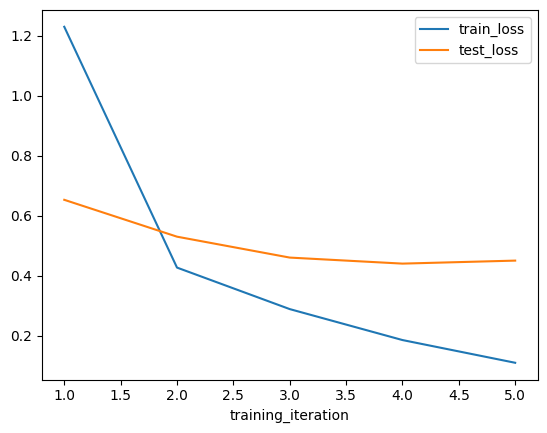

In [16]:
result.metrics_dataframe.plot("training_iteration", ["train_loss", "test_loss"])

## Using the trained model for prediction

The original Tensorflow quickstart tutorial doesn't actually go over loading the model for prediction, but let's see how you would complete the machine learning lifecycle with scalable batch prediction with Ray AIR!

### Loading the model for prediction

Here's how to load the model from a checkpoint and perform model inference on some sample data.

In [17]:
from ray.train.tensorflow import TensorflowCheckpoint

# Build a new model from scratch and load in the saved model weights
model = build_model()
model_weights = TensorflowCheckpoint.from_checkpoint(result.checkpoint).get_model_weights()

# Alternatively, load from a from checkpoint directory
# checkpoint_path = "~/ray_results/exp_name/trial_*/checkpoint_*"
# model_weights = TensorflowCheckpoint.from_directory(checkpoint_path).get_model_weights()

model.set_weights(model_weights)

In [25]:
import matplotlib.pyplot as plt

def predict_from_model(model, image, label):
    logits = model(image.reshape((1, 28, 28, 1)), training=False)[0]
    pred = tf.argmax(logits)
    plt.figure(figsize=(2, 2))
    plt.imshow(image.reshape((28, 28)))
    plt.show()
    print(f"Prediction = {pred}, Label = {label}")

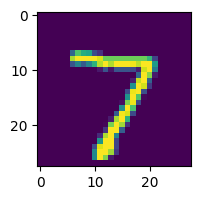

Prediction = 7, Label = [7]


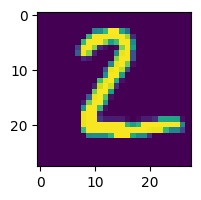

Prediction = 2, Label = [2]


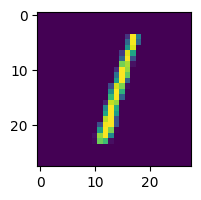

Prediction = 1, Label = [1]


In [26]:
_, test_ds = get_train_test_datasets(batch_size=1)
test_ds_iter = iter(test_ds)
sample_data = [next(test_ds_iter) for _ in range(3)]
for (image, label) in sample_data:
    predict_from_model(model, image.numpy(), label.numpy())

### Using Ray AIR for scalable batch prediction

However, we can also use Ray AIR's `BatchPredictor` class to do scalable prediction.

To create the `BatchPredictor`, we use the `BatchPredictor.from_checkpoint` method to load a model created by `model_definition` with the trained weights stored in the checkpoint. Again, the checkpoint passed in could be instantiated using `Checkpoint.from_directory(checkpoint_path)` instead.

In [29]:
import ray
from ray.train.batch_predictor import BatchPredictor
from ray.train.tensorflow import TensorflowPredictor

checkpoint = result.checkpoint

# Alternatively, load from a from checkpoint directory
# checkpoint_path = "~/ray_results/exp_name/trial_*/checkpoint_*"
# checkpoint = TensorflowCheckpoint.from_directory(checkpoint_path)

batch_predictor = BatchPredictor.from_checkpoint(
    checkpoint,
    TensorflowPredictor,
    model_definition=build_model
)

Batch predictors work with Ray Datasets. Here, we create a Ray Dataset of images from our test set.

TODO

In [30]:
# from ray.data.datasource import SimpleTensorFlowDatasource

# def factory():
#     mnist = tf.keras.datasets.mnist

#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train / 255.0, x_test / 255.0
    
#     return tf.data.Dataset.from_tensor_slices(x_test).batch(32)

# # TODO: This doesn't actually work as input to BatchPredictor...
# test_images_ds = ray.data.read_datasource(
#     SimpleTensorFlowDatasource(),
#     parallelism=1,
#     dataset_factory=factory,
# )

In [31]:
def get_test_data():
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    return x_test, y_test

x_test, y_test = get_test_data()
test_images_ds = ray.data.from_items(x_test)

Let's run `BatchPredictor.predict` on our Ray Dataset. This will distribute the prediction across a specified number of workers!

In [ ]:
predict_results = batch_predictor.predict(test_images_ds)

`predict_results` is also a Ray Dataset, and we can take a look at the predictions inside:

In [ ]:
predict_results.show()

Our model outputs logits, but we want the actual predicted labels. We can convert the logits to labels by performing a map on `predict_results`, taking the `argmax` of each model output. Then, we can compute the accuracy by comparing to the test set labels!

In [34]:
predicted_classes = predict_results.map_batches(
    lambda batch: [pred.argmax(0) for pred in batch["predictions"]], 
    batch_format="pandas"
)
predicted_classes_np = predicted_classes.take_all()

pred_accuracy = (predicted_classes_np == y_test).astype(int).sum() / len(predicted_classes_np)
print("Prediction Accuracy =", pred_accuracy)

Map_Batches: 100%|██████████| 200/200 [00:04<00:00, 46.16it/s]


Prediction Accuracy = 0.8744


## Summary

This tutorial demonstrated how a few lines of code with Ray AIR API's can allow you to scale up your Tensorflow model training.

We learned how to:
- enable distributed training using Ray Train abstractions
- save and retrieve model checkpoints via Ray AIR
- load a model for batch prediction

In our [other examples](air-examples-ref) you can learn how to do more things with the Ray AIR API, such as **serving your model with Ray Serve** or **tune your hyperparameters with Ray Tune**. You can also learn how to **construct Ray Datasets** to leverage Ray AIR’s **preprocessing** API.

We hope this tutorial gave you a good starting point to leverage Ray AIR. If you have any questions, suggestions, or run into any problems pelase reach out on [Discuss](https://discuss.ray.io/), [GitHub](https://github.com/ray-project/ray) or the [Ray Slack](https://forms.gle/9TSdDYUgxYs8SA9e8)!